# Graph Clustering Methods

In [2]:
import pickle
from gerrypy.data.load import *
from gerrypy.analyze.viz import *
import numpy as np
import pandas as pd
import itertools
import scipy
from sklearn.cluster import SpectralClustering
import dissimilarity
import networkx as nx
import random 

/opt/anaconda3/envs/gerry/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/opt/anaconda3/envs/gerry/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Graph-based k-means Clustering

Algorithm by Adam Schenker, Graph-Theoretic Techniques for Web Content Mining
Link: https://scholarcommons.usf.edu/cgi/viewcontent.cgi?article=2466&context=etd;Graph-theoretic

In [ ]:
# THIS CODE IS STILL IN DEVELOPMENT. THERE WILL BE MANY BUGS AND PERFORMANCE ISSUES

In [6]:
state_df, G, lengths, edge_dists = load_opt_data("NC")
plans = pickle.load(open('NC_test_plans.p', 'rb'))

In [7]:
def generate_graph_maps(G, maps): 
    graph_maps = []
    all_edges = G.edges()

    for m in maps: 
        G_map = G.copy()
        G_map.remove_edges_from(all_edges)    
        for district in m: 
            for i in range(1, len(district)): 
                e = (district[i-1], district[i])
                G_map.add_edge(*e)
        graph_maps.append(G_map)
    return graph_maps

In [8]:
graph_maps = generate_graph_maps(G, plans)

In [ ]:
def graph_k_means(graph_maps, k): 
    """
    Algorithm by Adam Schenker, 
    Graph-Theoretic Techniques for Web Content Mining 
    Link: https://scholarcommons.usf.edu/cgi/viewcontent.cgi?article=2466&context=etd;Graph-theoretic
    """
    clusters = [[] for x in range(k)]
    random.shuffle(graph_maps)
    for i in range(len(graph_maps)): 
        clusters[i % k].append(graph_maps[i]) 
    
    medians = []
    
    while True: 
        prev_medians = medians
        medians = []
        for i in range(0, k):   
            print("Median: {0}".format(i))
            dist_matrix = graph_dist_matrix(clusters[i])
            medians[i] = compute_graph_median(clusters[i], dist_matrix)

        clusters = [[] for x in range(k)]
        for graph in graph_maps: 
            dists_to_median = np.zeros(k)
            for i in range(0, len(medians)):
                dist = 0
                for v in nx.optimize_graph_edit_distance(graph, medians[i]):
                    dist = v
                dist = 1 / v
                dists_to_median[i] = dist 
            clusters[np.argmin(dist_to_median)].append(graph)
        
        isIdentical = True 
        for i in range(0, k): 
            if medians[i] != prev_medians[i]:
                isIdentical = False
        if isIdentical == True: 
            return medians

def graph_dist_matrix(graph_maps): 
    dim = len(graph_maps)
    dist_matrix = np.zeros((dim, dim))
    count = 0
    i = 0
    j = 0
    
    for two_maps in itertools.product(graph_maps, graph_maps):
        if i >= j:  
            dist = 0 
            for v in nx.optimize_graph_edit_distance(two_maps[0], two_maps[1]): 
                dist = v 
            dist = 1 / dist # Get distance rather than similarity matrix
            dist_matrix[i][j] = dist
            dist_matrix[j][i] = dist
        count += 1
        if count % dimension == 0:
            i += 1
        j = count % dimension

    return dist_matrix

def compute_graph_median(graph_maps, dist_matrix): 
    """
    Compute the set median Graph.
    See: Advances in Pattern Recognition - ICAPR 2011 p.5
    """
    column_sums = dist_matrix.mean(axis=0)
    return graph_maps[np.argmax(column_sums)]

In [ ]:
graph_k_means(graph_maps, 10)

### Spectral Clustering representing a plan as a node in graph

In [18]:
def align_plans(plans): 
    """
    Given 3-D tensor with 1st dimension representing set of maps, second dimension, the set of districts, 
    and the third dimension the blocks in a district, align the districts approximately with one another
    """
    transposed_maps = np.transpose(plans, (0, 2,1))
    dimension = maps.shape[0] 
    aligned_maps = []
    for i in range(1, dimension): 
        mult = plans[0] @ transposed_maps[i]
        aligned_map = []
        for j in range (0, mult.shape[0]):
            row = mult[j]
            index = np.argmax(row)
            aligned_map.append(plans[i][index][:])
            mult[:,index] = 0
            
        aligned_maps.append(aligned_map)
    first_plan = np.expand_dims(plans[0], axis=0)
    aligned_maps = np.array(aligned_maps)
    return np.append(first_plan, aligned_maps, 0)


In [19]:
plans = pickle.load(open('NC_test_plans.p', 'rb'))
bin_maps = dissimilarity.convert_plans(plans, 2195)

In [20]:
maps = bin_maps.reshape(271, -1)
maps.shape

(271, 28535)

In [21]:
num_clusters = 5

In [22]:
clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize").fit_predict(maps)

/opt/anaconda3/envs/gerry/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [23]:
clustering

array([0, 4, 3, 3, 0, 4, 2, 1, 2, 3, 3, 3, 2, 4, 3, 0, 4, 3, 1, 0, 4, 4,
       3, 1, 0, 2, 3, 0, 4, 1, 3, 4, 0, 4, 2, 1, 4, 2, 2, 1, 2, 3, 0, 0,
       1, 2, 1, 4, 4, 0, 4, 0, 2, 2, 0, 0, 4, 2, 1, 1, 2, 2, 0, 3, 3, 3,
       3, 1, 1, 3, 2, 2, 0, 0, 1, 2, 2, 3, 2, 3, 2, 3, 4, 0, 0, 2, 0, 0,
       2, 2, 4, 4, 4, 0, 2, 3, 3, 1, 2, 1, 1, 1, 2, 0, 2, 0, 2, 2, 2, 0,
       2, 4, 0, 3, 3, 0, 1, 2, 2, 2, 0, 3, 3, 1, 3, 4, 1, 2, 3, 1, 2, 1,
       3, 0, 0, 2, 1, 1, 3, 4, 1, 0, 1, 1, 0, 1, 3, 1, 3, 4, 1, 1, 1, 2,
       1, 4, 3, 0, 0, 2, 1, 0, 3, 3, 1, 2, 0, 0, 2, 3, 1, 1, 0, 1, 4, 2,
       4, 0, 3, 0, 3, 0, 2, 2, 1, 4, 1, 3, 2, 0, 1, 2, 2, 3, 4, 0, 0, 4,
       2, 0, 0, 1, 4, 3, 2, 2, 2, 0, 2, 4, 2, 2, 0, 1, 0, 3, 1, 0, 0, 4,
       2, 2, 3, 1, 4, 4, 3, 3, 0, 1, 0, 2, 2, 4, 2, 3, 0, 2, 0, 0, 4, 2,
       1, 1, 3, 0, 2, 2, 0, 2, 4, 4, 2, 2, 2, 4, 0, 2, 3, 2, 0, 2, 2, 2,
       4, 2, 2, 4, 1, 4, 3])

In [24]:
selected_maps = []
cluster_labels = np.arange(num_clusters)
clustering.shape[0]
for i in range(0, clustering.shape[0]): 
    if clustering[i] in cluster_labels:
        selected_maps.append(bin_maps[i])
        cluster_labels[clustering[i]] = -1        
        
selected_maps = np.asarray(selected_maps)

In [25]:
output_maps = dissimilarity.convert_back(selected_maps)

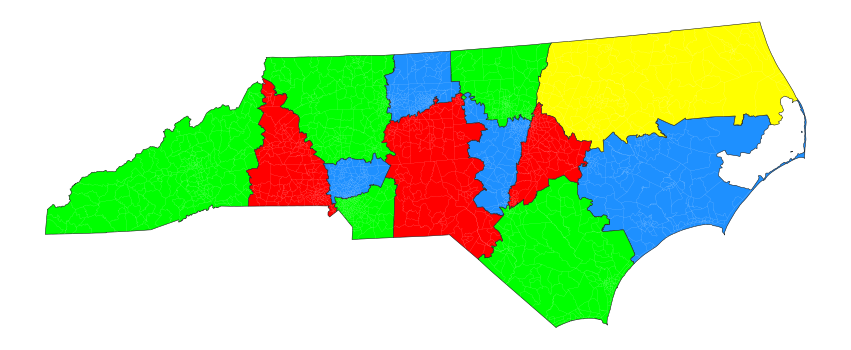

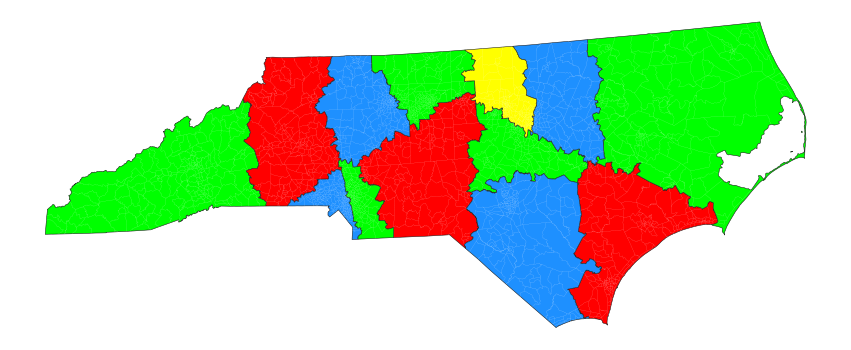

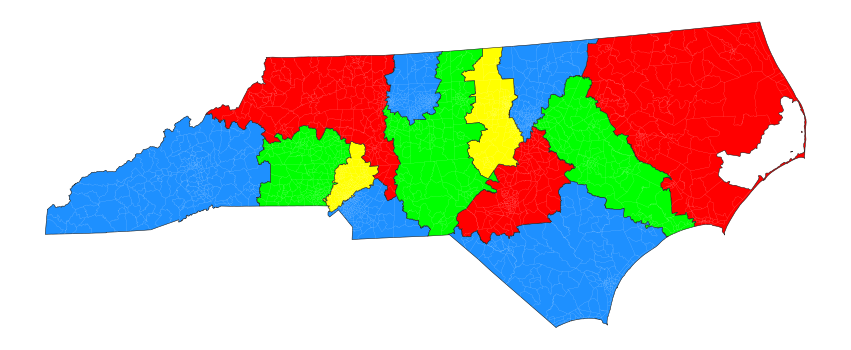

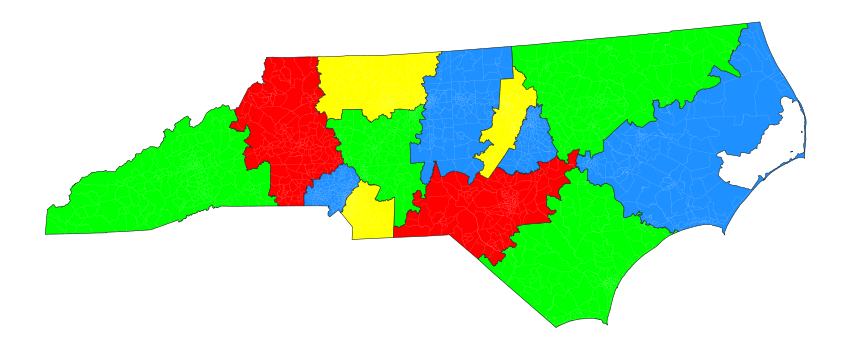

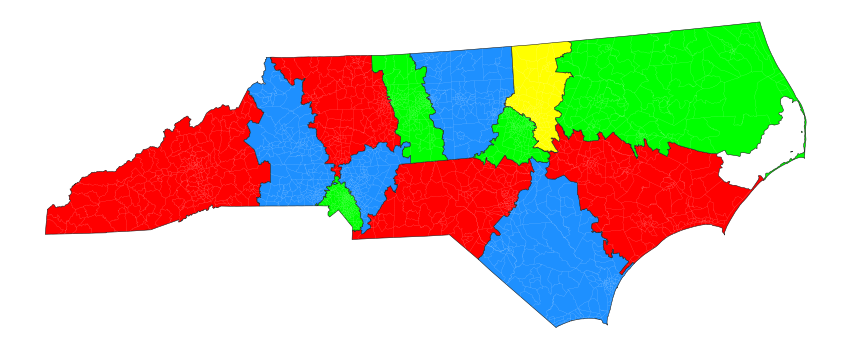

In [26]:
tract_shapes = load_tract_shapes('NC')
for plan in output_maps:
    color_map(tract_shapes, {ix: d for ix, d in enumerate(plan)})